In [1]:
#Dependencies
import pandas as pd
import numpy as np
#from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
import itertools
import os

from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tqdm
import matplotlib.pyplot as plt

In [4]:
cs_data_csv = pd.read_csv('data/course_information.csv')
cs_data = pd.DataFrame(cs_data_csv)
cs_data = cs_data.drop(['cs_content', 'cs_rating'], axis=1)
cs_data.rename(columns={'cs_num': 'item'}, inplace=True)
cs_data

,item,cs_title,cs_category,cs_topic,cs_level,cs_style
0,1,Write to Score High on the IELTS and TOEFL,ielts,writing,beginner,explanation
1,2,Mastering IELTS Writing: Task 2 (Achieve Band 7+),ielts,writing,intermediate,explanation
2,3,Get 7 - 9 in IELTS Speaking: IELTS Speaking Ma...,ielts,speaking,advanced,example
3,4,IELTS Writing: Achieve A Target 8 Score!,ielts,writing,advanced,example
4,5,Advanced IELTS Writing Process by Melbourne En...,ielts,writing,advanced,example
...,...,...,...,...,...,...
317,318,Succeed in IELTS Speaking and Writing (Achieve...,ielts,"writing,speaking",intermediate,explanation
318,319,IELTS Band 7+ in Hindi - The Ultimate course,ielts,"writing,speaking,reading,listening",intermediate,example
319,320,Vocabulary for IELTS (Speaking skill),ielts,vocabulary,beginner,example
320,321,PTE Ultimate Self-Preparation Resource,pte,"writing,speaking,reading,listening",advanced,example


In [5]:
cs_rating = pd.read_csv('data/user_ratings.csv')
cs_rating_df = pd.DataFrame(cs_rating)
cs_rating_df.rename(columns={'UserID': 'user'}, inplace=True)
cs_rating_df.rename(columns={'Rating': 'rating'}, inplace=True)
cs_rating_df.rename(columns={'Timestamp': 'timestamp'}, inplace=True)
cs_rating_df.rename(columns={'CourseID': 'item'}, inplace=True)
cs_rating_df

,user,item,rating,timestamp
0,1,316,1,1517927386
1,1,282,1,1643498109
2,1,290,1,1568400900
3,1,126,1,1591605461
4,1,217,2,1643591923
...,...,...,...,...
88990,5000,3,5,1476793303
88991,5000,156,5,1589457567
88992,5000,295,5,1538393338
88993,5000,42,5,1591434166


In [6]:
user_profile = pd.read_csv('data/user_profiles.csv')
user_profile_df = pd.DataFrame(user_profile)
user_profile_df.rename(columns={'UserID': 'user'}, inplace=True)
user_profile_df.rename(columns={'PreferredCategory': 'pf_category'}, inplace=True)
user_profile_df.rename(columns={'PreferredTopic': 'pf_topic'}, inplace=True)
user_profile_df.rename(columns={'Level': 'pf_level'}, inplace=True)
user_profile_df.rename(columns={'PreferredStyle': 'pf_style'}, inplace=True)
user_profile_df.rename(columns={'AimScore': 'aimscore'}, inplace=True)
user_profile_df.rename(columns={'Gender': 'gender'}, inplace=True)
user_profile_df.rename(columns={'Age': 'age'}, inplace=True)
user_profile_df

,user,gender,age,pf_category,pf_topic,pf_style,pf_level,aimscore
0,1,Female,26,ielts,"vocabulary,grammar,speaking",example,intermediate,6.0
1,2,Male,29,ielts,"vocabulary,writing",explanation,beginner,5.0
2,3,Female,53,ielts,"speaking,reading",example,beginner,5.5
3,4,Female,26,ielts,"writing,reading",example,beginner,7.5
4,5,Male,21,ielts,"reading,grammar",explanation,intermediate,6.0
...,...,...,...,...,...,...,...,...
4995,4996,Female,60,ielts,reading,example,advanced,5.0
4996,4997,Female,29,ielts,"reading,grammar",explanation,beginner,6.0
4997,4998,Male,42,ielts,listening,example,advanced,5.0
4998,4999,Female,34,ielts,"speaking,grammar",example,intermediate,5.5


In [7]:
merged_df = pd.merge(cs_data, cs_rating_df, on='item', how='inner')
merged_df = pd.merge(merged_df, user_profile_df, on='user', how='inner')

desired_order = ['user','item','rating','cs_title','cs_category','cs_topic','cs_style','cs_level','pf_category','pf_topic','pf_style','pf_level','aimscore', 'age','gender','timestamp']
merged_df = merged_df[desired_order]

merged_df

,user,item,rating,cs_title,cs_category,cs_topic,cs_style,cs_level,pf_category,pf_topic,pf_style,pf_level,aimscore,age,gender,timestamp
0,35,1,5,Write to Score High on the IELTS and TOEFL,ielts,writing,explanation,beginner,ielts,"grammar,writing",explanation,beginner,7.0,45,Female,1474383913
1,35,55,5,IELTS Writing Task 1 (General): Master Letter ...,ielts,writing,explanation,beginner,ielts,"grammar,writing",explanation,beginner,7.0,45,Female,1655916839
2,35,59,4,Father IELTS -- Test Preparation,ielts,"writing,speaking,reading,listening",example,beginner,ielts,"grammar,writing",explanation,beginner,7.0,45,Female,1645231900
3,35,67,5,Prepare for IELTS,ielts,"writing,speaking,reading,listening",explanation,beginner,ielts,"grammar,writing",explanation,beginner,7.0,45,Female,1599096320
4,35,72,5,IELTS Academic,ielts,"writing,speaking,reading,listening",explanation,beginner,ielts,"grammar,writing",explanation,beginner,7.0,45,Female,1524923299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88990,4750,272,2,Crack 79+ in PTE Reading | All tips | Grammar ...,pte,reading,explanation,beginner,pte,"grammar,writing",example,advanced,50.0,59,Male,1660770091
88991,4750,276,1,IELTS Listening Strategies - From band 6 to Ba...,ielts,listening,explanation,intermediate,pte,"grammar,writing",example,advanced,50.0,59,Male,1452480887
88992,4750,290,2,PTE Listening Made Easy,pte,listening,explanation,intermediate,pte,"grammar,writing",example,advanced,50.0,59,Male,1622625569
88993,4750,294,1,IELTS Reading for (Academic & General),ielts,reading,example,intermediate,pte,"grammar,writing",example,advanced,50.0,59,Male,1619084651


In [9]:
merged_df = merged_df.sort_values(["user","rating"]).fillna(0)
merged_df = merged_df.reset_index(drop=True)
merged_df.head(10)

,user,item,rating,cs_title,cs_category,cs_topic,cs_style,cs_level,pf_category,pf_topic,pf_style,pf_level,aimscore,age,gender,timestamp
0,1,126,1,PTE Academic (English Test) - Mastering Readin...,pte,reading,explanation,intermediate,ielts,"vocabulary,grammar,speaking",example,intermediate,6.0,26,Female,1591605461
1,1,282,1,PTE academic test listening module,pte,listening,example,beginner,ielts,"vocabulary,grammar,speaking",example,intermediate,6.0,26,Female,1643498109
2,1,290,1,PTE Listening Made Easy,pte,listening,explanation,intermediate,ielts,"vocabulary,grammar,speaking",example,intermediate,6.0,26,Female,1568400900
3,1,316,1,PTE Reading Academic test,pte,reading,example,beginner,ielts,"vocabulary,grammar,speaking",example,intermediate,6.0,26,Female,1517927386
4,1,6,2,IELTS WRITING- GET THE BEST RESULTS,ielts,writing,explanation,beginner,ielts,"vocabulary,grammar,speaking",example,intermediate,6.0,26,Female,1623585642
5,1,61,2,IELTS Writing: Task 2 (expect band 7 - 9),ielts,writing,example,beginner,ielts,"vocabulary,grammar,speaking",example,intermediate,6.0,26,Female,1661541807
6,1,217,2,IELTS Preparation EP-4 - Listening Section -1,ielts,listening,explanation,intermediate,ielts,"vocabulary,grammar,speaking",example,intermediate,6.0,26,Female,1643591923
7,1,26,3,Succeed in IELTS Speaking,ielts,speaking,explanation,advanced,ielts,"vocabulary,grammar,speaking",example,intermediate,6.0,26,Female,1519560159
8,1,70,3,Complete Guide to IELTS,ielts,"writing,speaking,reading,listening",explanation,beginner,ielts,"vocabulary,grammar,speaking",example,intermediate,6.0,26,Female,1462182591
9,1,145,3,IELTS Masterclass Achieve Band 7+ in IELTS Spe...,ielts,speaking,explanation,beginner,ielts,"vocabulary,grammar,speaking",example,intermediate,6.0,26,Female,1561306827


In [10]:
df = merged_df

cs_category_values = ['ielts', 'pte']
cs_topic_values = ['writing', 'speaking', 'reading', 'listening', 'vocabulary', 'grammar']
pf_category_values = cs_category_values
pf_topic_values = cs_topic_values

for category in cs_category_values:
    df[f'cs_category_{category}'] = 0

for topic in cs_topic_values:
    df[f'cs_topic_{topic}'] = 0

for category in pf_category_values:
    df[f'pf_category_{category}'] = 0

for topic in pf_topic_values:
    df[f'pf_topic_{topic}'] = 0

df['cs_category_ielts'] = df['cs_category'].apply(lambda x: 1 if 'ielts' in x else 0)
df['cs_category_pte'] = df['cs_category'].apply(lambda x: 1 if 'pte' in x else 0)

df['pf_category_ielts'] = df['pf_category'].apply(lambda x: 1 if 'ielts' in x else 0)
df['pf_category_pte'] = df['pf_category'].apply(lambda x: 1 if 'pte' in x else 0)


topics = ['writing', 'speaking', 'reading', 'listening', 'vocabulary', 'grammar']
for topic in topics:
    df[f'cs_topic_{topic}'] = df['cs_topic'].apply(lambda x: 1 if topic in x else 0)
    df[f'pf_topic_{topic}'] = df['pf_topic'].apply(lambda x: 1 if topic in x else 0)

def generate_age(x):
    if x < 10:
        return 9
    elif x < 20:
        return 19
    elif x < 30:
        return 29
    elif x < 40:
        return 39
    elif x < 50:
        return 49
    else:
        return 59

df['age'] = df['age'].apply(generate_age)

label_encoder = LabelEncoder()

df['cs_style'] = label_encoder.fit_transform(df['cs_style'])
df['cs_level'] = label_encoder.fit_transform(df['cs_level'])
df['pf_style'] = label_encoder.fit_transform(df['pf_style'])
df['pf_level'] = label_encoder.fit_transform(df['pf_level'])
df['gender'] = label_encoder.fit_transform(df['gender'])
df['aimscore'] = label_encoder.fit_transform(df['aimscore'])
df['age'] = label_encoder.fit_transform(df['age'])

#Delete Unnecessary Columns
df.drop('cs_category', axis=1, inplace=True)
df.drop('cs_topic', axis=1, inplace=True)
df.drop('pf_category', axis=1, inplace=True)
df.drop('pf_topic', axis=1, inplace=True)
df.drop('timestamp', axis=1, inplace=True)


In [11]:
df.head(15)

,user,item,rating,cs_title,cs_style,cs_level,pf_style,pf_level,aimscore,age,...,cs_topic_vocabulary,cs_topic_grammar,pf_category_ielts,pf_category_pte,pf_topic_writing,pf_topic_speaking,pf_topic_reading,pf_topic_listening,pf_topic_vocabulary,pf_topic_grammar
0,1,126,1,PTE Academic (English Test) - Mastering Readin...,1,2,0,2,2,1,...,0,0,1,0,0,1,0,0,1,1
1,1,282,1,PTE academic test listening module,0,1,0,2,2,1,...,0,0,1,0,0,1,0,0,1,1
2,1,290,1,PTE Listening Made Easy,1,2,0,2,2,1,...,0,0,1,0,0,1,0,0,1,1
3,1,316,1,PTE Reading Academic test,0,1,0,2,2,1,...,0,0,1,0,0,1,0,0,1,1
4,1,6,2,IELTS WRITING- GET THE BEST RESULTS,1,1,0,2,2,1,...,0,0,1,0,0,1,0,0,1,1
5,1,61,2,IELTS Writing: Task 2 (expect band 7 - 9),0,1,0,2,2,1,...,0,0,1,0,0,1,0,0,1,1
6,1,217,2,IELTS Preparation EP-4 - Listening Section -1,1,2,0,2,2,1,...,0,0,1,0,0,1,0,0,1,1
7,1,26,3,Succeed in IELTS Speaking,1,0,0,2,2,1,...,0,0,1,0,0,1,0,0,1,1
8,1,70,3,Complete Guide to IELTS,1,1,0,2,2,1,...,0,0,1,0,0,1,0,0,1,1
9,1,145,3,IELTS Masterclass Achieve Band 7+ in IELTS Spe...,1,1,0,2,2,1,...,0,0,1,0,0,1,0,0,1,1


In [12]:
def seq_dataset(df, sequence_length):
    sequences = []
    labels = []
    users = []
    items = []

    for i in range(len(df) - (sequence_length-1)):
        sequence = df[i:i+sequence_length].drop(['user', 'item', 'cs_title', 'rating'], axis=1).values
        label = df.iloc[i+sequence_length-1]['rating']
        user = df.iloc[i+sequence_length-1]['user']
        item = df.iloc[i+sequence_length-1]['item']
        
        sequences.append(sequence)
        labels.append(label-1)
        users.append(user)
        items.append(item)

    sequences = torch.tensor(sequences, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    users = torch.tensor(users, dtype=torch.int32)
    items = torch.tensor(items, dtype=torch.int32)
    
    dataset = TensorDataset(sequences, labels, users, items)
    
    return dataset

In [13]:
class LSTMActorCritic(nn.Module):
    def __init__(self, input_size, conv_channels, lstm_hidden_size, num_layers, output_size):
        super(LSTMActorCritic, self).__init__()
        self.drop_layer = nn.Dropout(p=0.05)
        self.lstm_hidden_size = lstm_hidden_size
        self.num_layers = num_layers
        self.conv1d = nn.Conv1d(input_size, conv_channels, kernel_size=5, padding=2) # 1D Convolutional Layer
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(conv_channels, lstm_hidden_size, num_layers, batch_first=True)  # LSTM Layer
        self.actor = nn.Sequential(
            nn.Linear(lstm_hidden_size, lstm_hidden_size),
            nn.ReLU(),
            nn.Linear(lstm_hidden_size, 5),
            nn.Softmax(dim=1)
        )
        self.critic = nn.Sequential(
            nn.Linear(lstm_hidden_size, lstm_hidden_size),
            nn.ReLU(),
            nn.Linear(lstm_hidden_size, 1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1) # Transpose input for Conv1D layer (batch_size, input_size, sequence_length)
        x = self.conv1d(x)  
        x = x.permute(0, 2, 1) # Transpose back to (batch_size, sequence_length, conv_channels)
        h0 = torch.zeros(self.num_layers, x.size(0), self.lstm_hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.lstm_hidden_size).to(device)
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))
        state = self.drop_layer(out[:, -1, :])
        policy_dist = self.actor(state)
        value_est = self.critic(state)
        return policy_dist, value_est, state

In [14]:
class Environment:
    def __init__(self, dataloader):
        self.dataloader = iter(dataloader)
        self.data = next(self.dataloader)

        self.state = self.data[0].to(device)
        self.rating = self.data[1]
        self.user = self.data[2]
        self.item = self.data[3]
                
        self.done = 0
    def reset(self):
        self.rating = self.next_data[1]
    def step(self, action):         
        accuracy_count = 0
        reward = self.rating
        
        for i in range(len(action)):
            if action[i] == reward[i]:
                accuracy_count += 1

        try:
            self.next_data = next(self.dataloader)
        except StopIteration:
            next_state = 0
            self.done = 1
        else:
            next_state = self.next_data[0]
            self.done = 0
        
        return next_state, reward, accuracy_count, self.done

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

user_course_rating_df = df  

user_df_train, user_df_test = train_test_split(user_course_rating_df, test_size=0.3, random_state=0, shuffle=False)

sequence_length = 3

seq_data = seq_dataset(user_df_train, sequence_length)


batch_size = 128
data_loader = DataLoader(seq_data, batch_size=batch_size, shuffle=False)

input_size = 23
conv_channels = 128
hidden_size = 128
num_layers = 1
output_size = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMActorCritic(input_size, conv_channels, hidden_size, num_layers, output_size).to(device)
critic_criterion = nn.MSELoss()
actor_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00002)

C:\Users\lgt11\AppData\Local\Temp\ipykernel_37648\3489257814.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  sequences = torch.tensor(sequences, dtype=torch.float32)


In [16]:
len(data_loader)

487

  2%|▏         | 1/50 [00:07<06:17,  7.70s/it]

Epoch [1/50], critic_Loss: 3.5621, actor_loss:1.6086100239528522, accuracy:0.20022795132757568


  4%|▍         | 2/50 [00:15<06:13,  7.79s/it]

Epoch [2/50], critic_Loss: 1.6363, actor_loss:1.5975788655467102, accuracy:0.21075866054515685


  6%|▌         | 3/50 [00:22<05:58,  7.62s/it]

Epoch [3/50], critic_Loss: 1.1508, actor_loss:1.5542211221718445, accuracy:0.2600089896298199


  8%|▊         | 4/50 [00:30<05:46,  7.53s/it]

Epoch [4/50], critic_Loss: 0.9809, actor_loss:1.5123204350226713, accuracy:0.31104119176806755


 10%|█         | 5/50 [00:37<05:37,  7.51s/it]

Epoch [5/50], critic_Loss: 0.8241, actor_loss:1.4731358103683596, accuracy:0.3524095418499374


 12%|█▏        | 6/50 [00:45<05:29,  7.49s/it]

Epoch [6/50], critic_Loss: 0.7065, actor_loss:1.4370883154918037, accuracy:0.3923010241756831


 14%|█▍        | 7/50 [00:52<05:24,  7.54s/it]

Epoch [7/50], critic_Loss: 0.6445, actor_loss:1.4078488330331915, accuracy:0.428002696888946


 16%|█▌        | 8/50 [01:00<05:16,  7.54s/it]

Epoch [8/50], critic_Loss: 0.6046, actor_loss:1.3824489694356428, accuracy:0.45583844350980834


 18%|█▊        | 9/50 [01:08<05:10,  7.56s/it]

Epoch [9/50], critic_Loss: 0.5707, actor_loss:1.3598538661639548, accuracy:0.4844607827399107


 20%|██        | 10/50 [01:15<05:03,  7.58s/it]

Epoch [10/50], critic_Loss: 0.5374, actor_loss:1.3401346461239292, accuracy:0.5026166243940027


 22%|██▏       | 11/50 [01:23<04:55,  7.57s/it]

Epoch [11/50], critic_Loss: 0.5004, actor_loss:1.3238367929106132, accuracy:0.5205477253025974


 24%|██▍       | 12/50 [01:30<04:48,  7.59s/it]

Epoch [12/50], critic_Loss: 0.4581, actor_loss:1.3094872361091128, accuracy:0.5404693870998812


 26%|██▌       | 13/50 [01:38<04:41,  7.61s/it]

Epoch [13/50], critic_Loss: 0.4137, actor_loss:1.2954497038706128, accuracy:0.5555270170481909


 28%|██▊       | 14/50 [01:46<04:33,  7.60s/it]

Epoch [14/50], critic_Loss: 0.3790, actor_loss:1.281576660869058, accuracy:0.57027964169904


 30%|███       | 15/50 [01:53<04:25,  7.59s/it]

Epoch [15/50], critic_Loss: 0.3551, actor_loss:1.2689489914406495, accuracy:0.587087038880149


 32%|███▏      | 16/50 [02:01<04:16,  7.56s/it]

Epoch [16/50], critic_Loss: 0.3366, actor_loss:1.2569896416008106, accuracy:0.6032041609143738


 34%|███▍      | 17/50 [02:08<04:08,  7.54s/it]

Epoch [17/50], critic_Loss: 0.3212, actor_loss:1.2447423119809349, accuracy:0.6148746267698334


 36%|███▌      | 18/50 [02:16<04:01,  7.56s/it]

Epoch [18/50], critic_Loss: 0.3086, actor_loss:1.2321946035909948, accuracy:0.6288567117218352


 38%|███▊      | 19/50 [02:23<03:54,  7.58s/it]

Epoch [19/50], critic_Loss: 0.2958, actor_loss:1.2198970405962433, accuracy:0.6424374739140206


 40%|████      | 20/50 [02:31<03:49,  7.64s/it]

Epoch [20/50], critic_Loss: 0.2838, actor_loss:1.2085836423251173, accuracy:0.6565961408803416


 42%|████▏     | 21/50 [02:39<03:40,  7.60s/it]

Epoch [21/50], critic_Loss: 0.2717, actor_loss:1.1977140049180455, accuracy:0.6663081516678974


 44%|████▍     | 22/50 [02:46<03:33,  7.61s/it]

Epoch [22/50], critic_Loss: 0.2604, actor_loss:1.1878839672468526, accuracy:0.6805631360965743


 46%|████▌     | 23/50 [02:54<03:24,  7.58s/it]

Epoch [23/50], critic_Loss: 0.2482, actor_loss:1.1778986571505818, accuracy:0.6891835489774296


 48%|████▊     | 24/50 [03:01<03:15,  7.52s/it]

Epoch [24/50], critic_Loss: 0.2370, actor_loss:1.1679540970487026, accuracy:0.7018653481876265


 50%|█████     | 25/50 [03:09<03:08,  7.52s/it]

Epoch [25/50], critic_Loss: 0.2260, actor_loss:1.1576419997753793, accuracy:0.7107426076347642


 52%|█████▏    | 26/50 [03:16<02:59,  7.47s/it]

Epoch [26/50], critic_Loss: 0.2142, actor_loss:1.1463891101324093, accuracy:0.7245962693036248


 54%|█████▍    | 27/50 [03:23<02:51,  7.45s/it]

Epoch [27/50], critic_Loss: 0.2038, actor_loss:1.1343421703491368, accuracy:0.740552862233923


 56%|█████▌    | 28/50 [03:31<02:44,  7.46s/it]

Epoch [28/50], critic_Loss: 0.1932, actor_loss:1.1215448372173114, accuracy:0.7533791376376537


 58%|█████▊    | 29/50 [03:39<02:37,  7.49s/it]

Epoch [29/50], critic_Loss: 0.1843, actor_loss:1.1079130153146857, accuracy:0.7660769897582431


 60%|██████    | 30/50 [03:46<02:29,  7.46s/it]

Epoch [30/50], critic_Loss: 0.1746, actor_loss:1.0930644758428147, accuracy:0.7831091276848493


 62%|██████▏   | 31/50 [03:53<02:22,  7.49s/it]

Epoch [31/50], critic_Loss: 0.1653, actor_loss:1.079082969522574, accuracy:0.7979099110668765


 64%|██████▍   | 32/50 [04:01<02:14,  7.45s/it]

Epoch [32/50], critic_Loss: 0.1567, actor_loss:1.0656823059371854, accuracy:0.8146049378752368


 66%|██████▌   | 33/50 [04:08<02:07,  7.50s/it]

Epoch [33/50], critic_Loss: 0.1480, actor_loss:1.053812396966946, accuracy:0.8275435836517161


 68%|██████▊   | 34/50 [04:16<01:59,  7.45s/it]

Epoch [34/50], critic_Loss: 0.1402, actor_loss:1.0421186138472274, accuracy:0.8431470125533759


 70%|███████   | 35/50 [04:23<01:51,  7.47s/it]

Epoch [35/50], critic_Loss: 0.1324, actor_loss:1.0313867873969265, accuracy:0.8537098275917424


 72%|███████▏  | 36/50 [04:31<01:44,  7.46s/it]

Epoch [36/50], critic_Loss: 0.1247, actor_loss:1.0213306093362813, accuracy:0.8656852987446624


 74%|███████▍  | 37/50 [04:38<01:36,  7.45s/it]

Epoch [37/50], critic_Loss: 0.1175, actor_loss:1.011944405474457, accuracy:0.876986547661091


 76%|███████▌  | 38/50 [04:46<01:30,  7.53s/it]

Epoch [38/50], critic_Loss: 0.1108, actor_loss:1.0029414957064133, accuracy:0.886361447330401


 78%|███████▊  | 39/50 [04:53<01:22,  7.51s/it]

Epoch [39/50], critic_Loss: 0.1041, actor_loss:0.9951640437271071, accuracy:0.8943076379747649


 80%|████████  | 40/50 [05:01<01:14,  7.48s/it]

Epoch [40/50], critic_Loss: 0.0977, actor_loss:0.9865686782086899, accuracy:0.9041320191350692


 82%|████████▏ | 41/50 [05:08<01:07,  7.45s/it]

Epoch [41/50], critic_Loss: 0.0914, actor_loss:0.9788952085516536, accuracy:0.9139403473849809


 84%|████████▍ | 42/50 [05:16<00:59,  7.44s/it]

Epoch [42/50], critic_Loss: 0.0865, actor_loss:0.9713759649950376, accuracy:0.9229620830256525


 86%|████████▌ | 43/50 [05:23<00:52,  7.44s/it]

Epoch [43/50], critic_Loss: 0.0803, actor_loss:0.9637027530944323, accuracy:0.9314540726233667


 88%|████████▊ | 44/50 [05:30<00:44,  7.43s/it]

Epoch [44/50], critic_Loss: 0.0766, actor_loss:0.9571232319612523, accuracy:0.9387902526728096


 90%|█████████ | 45/50 [05:38<00:37,  7.46s/it]

Epoch [45/50], critic_Loss: 0.0725, actor_loss:0.9513687979758887, accuracy:0.9450508877259447


 92%|█████████▏| 46/50 [05:45<00:29,  7.46s/it]

Epoch [46/50], critic_Loss: 0.0683, actor_loss:0.9457954585674607, accuracy:0.952836549266382


 94%|█████████▍| 47/50 [05:53<00:22,  7.50s/it]

Epoch [47/50], critic_Loss: 0.0651, actor_loss:0.9417437007784598, accuracy:0.9572832054451472


 96%|█████████▌| 48/50 [06:01<00:15,  7.52s/it]

Epoch [48/50], critic_Loss: 0.0621, actor_loss:0.9383485068775546, accuracy:0.9612161684913475


 98%|█████████▊| 49/50 [06:08<00:07,  7.49s/it]

Epoch [49/50], critic_Loss: 0.0593, actor_loss:0.9359133739246235, accuracy:0.9643785918387003


100%|██████████| 50/50 [06:15<00:00,  7.52s/it]

Epoch [50/50], critic_Loss: 0.0566, actor_loss:0.9332701927337803, accuracy:0.9667062638456352


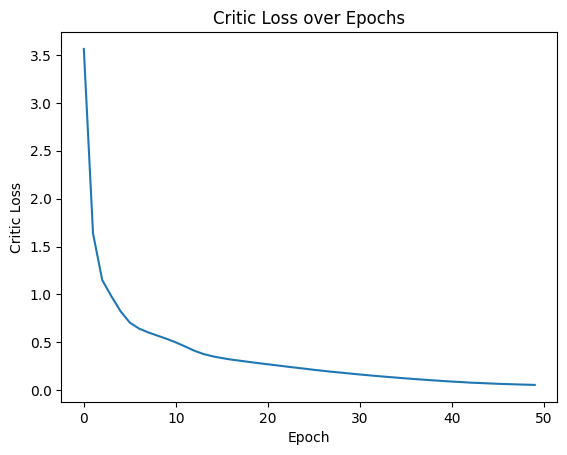

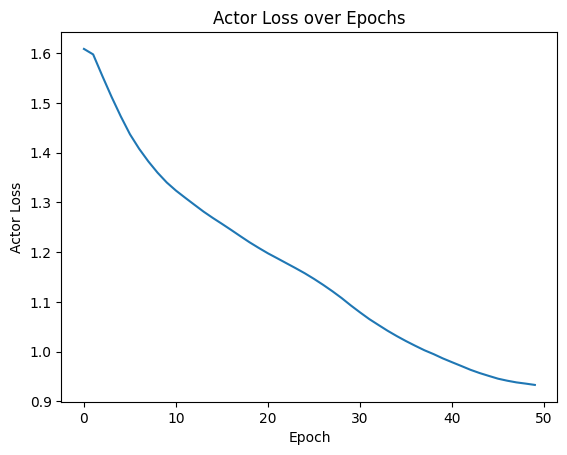

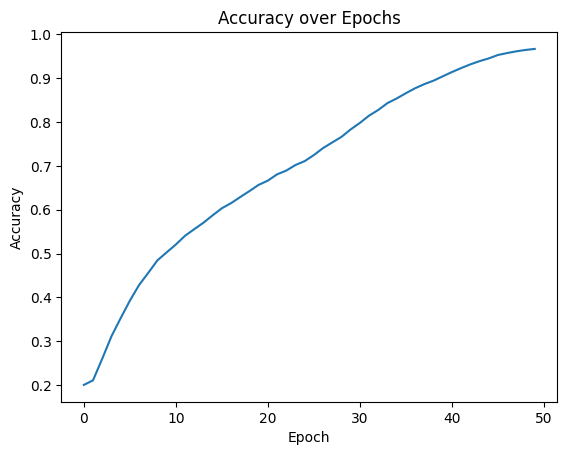

In [17]:
# training loop 
critic_losses = []
actor_losses = []
accuracies = []
num_epochs = 50
for epoch in tqdm.tqdm(range(num_epochs)):
    env = Environment(data_loader)
    total_critic_loss = 0
    total_actor_loss = 0
    total_count = 0
    done = env.done
    state = env.state

    while not done:
        optimizer.zero_grad()
        policy_dist, value_est, st = model(state)

        action = torch.multinomial(policy_dist, 1)
        next_state, reward, count, done = env.step(action)
        
        actor_loss = actor_criterion(policy_dist, reward.long())
        critic_loss = critic_criterion(value_est, reward.unsqueeze(1))

        actor_loss.backward(retain_graph=True)
        critic_loss.backward()
        
        optimizer.step()
    
        total_critic_loss += critic_loss.item()
        total_actor_loss += actor_loss.item()
        total_count += count

        if done == 0:
            state = next_state
            env.reset()
    
    average_critic_loss = total_critic_loss / len(data_loader)
    average_actor_loss = total_actor_loss / len(data_loader)
    accuracy = total_count / (((len(data_loader)-1) * 128) + 86)
    critic_losses.append(average_critic_loss)
    actor_losses.append(average_actor_loss)
    accuracies.append(accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], critic_Loss: {average_critic_loss:.4f}, actor_loss:{average_actor_loss}, accuracy:{accuracy}')
# critic loss
plt.figure()
plt.plot(range(num_epochs), critic_losses)
plt.xlabel('Epoch')
plt.ylabel('Critic Loss')
plt.title('Critic Loss over Epochs')

# Actor Loss 
plt.figure()
plt.plot(range(num_epochs), actor_losses)
plt.xlabel('Epoch')
plt.ylabel('Actor Loss')
plt.title('Actor Loss over Epochs')

# accuracy
plt.figure()
plt.plot(range(num_epochs), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')

plt.show()

In [18]:
folder_path = 'trained_model'
#model save
torch.save({
    'drl_model_state_dict': model.state_dict(),
    'drl_optimizer_state_dict': optimizer.state_dict(),
},  os.path.join(folder_path, 'drl_model_1.pth'))

Model evaluation part

In [19]:
user_course_rating_df = df

user_df_train, user_df_test = train_test_split(user_course_rating_df, test_size=0.3, random_state=0, shuffle=False)

sequence_length = 3

test_lstm_seq_data = seq_dataset(user_df_test, sequence_length)

batch_size = 128
test_lstm_data_loader = DataLoader(test_lstm_seq_data, batch_size=batch_size, shuffle=False)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 23
conv_channels = 128
hidden_size = 128
num_layers = 1
output_size = 1

t_model = LSTMActorCritic(input_size, conv_channels, hidden_size, num_layers, output_size).to(device)
t_optimizer = optim.Adam(t_model.parameters(), lr=0.00002)

checkpoint = torch.load('trained_model/drl_model_1.pth')
t_model.load_state_dict(checkpoint['drl_model_state_dict'])
t_optimizer.load_state_dict(checkpoint['drl_optimizer_state_dict'])


In [21]:
len(test_lstm_data_loader)

209

last_num:73
Total accuracy: 0.9800, Total RMSE: 0.1834, Total MAE: 0.0240, Total F1 score: 0.9800


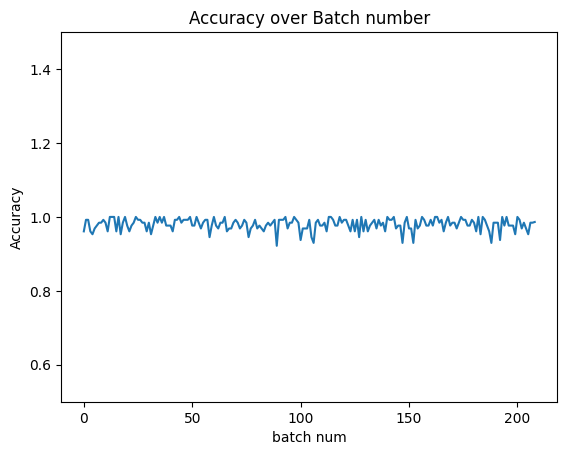

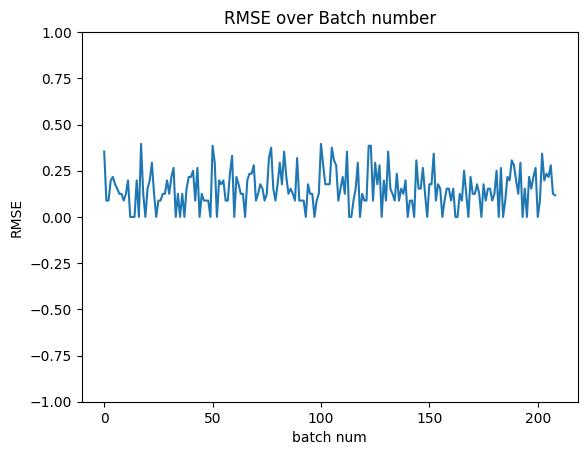

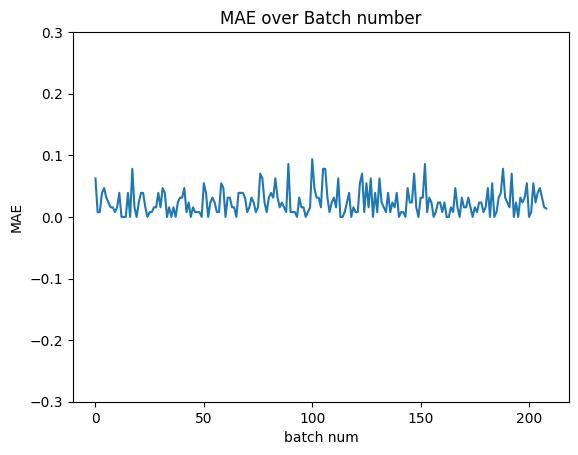

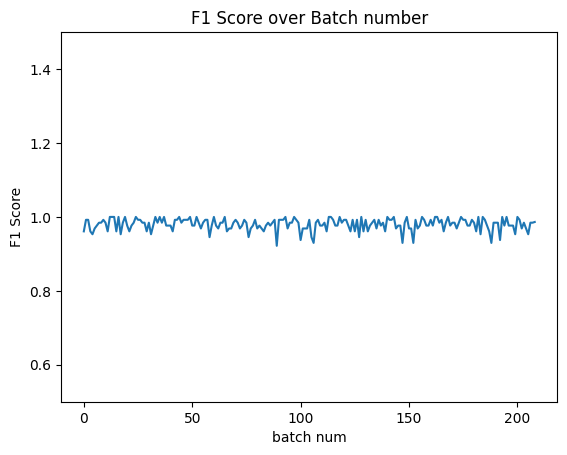

In [22]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score

total_count = 0
total_size = 0
true_labels = []
predicted_labels = []
batch_acc = []
batch_rmse = []
batch_mae = []
batch_f1score = []
check_batch_num = 0


# model evaluation
t_model.eval()  
with torch.no_grad():
    env = Environment(test_lstm_data_loader)
    done = env.done
    state = env.state
    while not done:
        check_batch_num += 1
        policy_dist, value_est, st = t_model(state)

        action = torch.argmax(policy_dist, dim=1)

        next_state, reward, count, done = env.step(action)
        total_count += count
        total_size += policy_dist.size(0)
        
        true_labels.extend(reward.cpu().numpy())
        predicted_labels.extend(action.cpu().numpy())

        batch_accuracy = count / policy_dist.size(0)
        batch_RMSE = mean_squared_error(reward, action, squared=False)
        batch_MAE = mean_absolute_error(reward, action)
        batch_F1 = f1_score(reward, action, average='micro')

        batch_acc.append(batch_accuracy)
        batch_rmse.append(batch_RMSE)
        batch_mae.append(batch_MAE)
        batch_f1score.append(batch_F1)

        if done == 1:
            last_num = policy_dist.size(0)
            print(f'last_num:{last_num}')
        if done == 0:
            env.reset()
            state = next_state
            
    # accuracy
    eval_accuracy = total_count / (((len(test_lstm_data_loader)-1)*128)+last_num)
    # RMSE
    rmse = mean_squared_error(true_labels, predicted_labels, squared=False)
    # MAE
    mae = mean_absolute_error(true_labels, predicted_labels)
    # F1 score
    f1 = f1_score(true_labels, predicted_labels, average='micro')

    print(f'Total accuracy: {eval_accuracy:.4f}, Total RMSE: {rmse:.4f}, Total MAE: {mae:.4f}, Total F1 score: {f1:.4f}')

# accuracy
plt.figure()
plt.plot(range(check_batch_num), batch_acc)
plt.xlabel('batch num')
plt.ylabel('Accuracy')
plt.title('Accuracy over Batch number')
plt.ylim(0.5, 1.5)

# RMSE
plt.figure()
plt.plot(range(check_batch_num), batch_rmse)
plt.xlabel('batch num')
plt.ylabel('RMSE')
plt.title('RMSE over Batch number')
plt.ylim(-1, 1)

# MAE
plt.figure()
plt.plot(range(check_batch_num), batch_mae)
plt.xlabel('batch num')
plt.ylabel('MAE')
plt.title('MAE over Batch number')
plt.ylim(-0.3, 0.3)

# F1 score
plt.figure()
plt.plot(range(check_batch_num), batch_f1score)
plt.xlabel('batch num')
plt.ylabel('F1 Score')
plt.title('F1 Score over Batch number')
plt.ylim(0.5, 1.5)

plt.show()
